<a href="https://colab.research.google.com/github/Sushmithaa-Pandian/DOA_estimation/blob/main/low_snapshots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot

from scipy.stats import norm
from scipy import stats

from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_excel('/content/gdrive/MyDrive/datasetmodsnap.xlsx')

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state = 1)


In [ ]:
j=df.iloc(0)

In [ ]:
train_stats = train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
angle1,288.0,45.034722,27.424248,0.0000,20.000000,45.00000,70.000000,90.0000
angle2,288.0,43.559028,27.167502,0.0000,20.000000,42.50000,65.000000,90.0000
abs1,288.0,0.390768,0.214567,0.0064,0.216875,0.37420,0.534400,0.9399
abs2,288.0,0.391799,0.217066,0.0111,0.213825,0.34890,0.554625,0.9387
abs3,288.0,0.375769,0.213472,0.0163,0.202275,0.34785,0.534500,0.9160
abs4,288.0,0.424078,0.217214,0.0474,0.245475,0.40345,0.588150,0.9320
abs5,288.0,0.381460,0.205224,0.0309,0.224525,0.34680,0.524400,0.9385
abs6,288.0,0.395968,0.216233,0.0113,0.228300,0.35685,0.542550,0.9151
abs7,288.0,0.392057,0.208532,0.0043,0.240875,0.35915,0.536025,0.8717
abs8,288.0,0.400792,0.203305,0.0254,0.225500,0.39340,0.558875,0.8844


In [ ]:
train_X = train
test_X = test

In [ ]:
def get_labels(df):
    angle1 = df.pop('angle1')
    angle1 = np.array(angle1)
    angle2 = df.pop('angle2')
    angle2 = np.array(angle2)
    return (angle1,angle2)

In [ ]:
train_y = get_labels(train)
test_y = get_labels(test)

In [ ]:
inputs = tf.keras.layers.Input(shape=(20,))

#Add dense layers to the input layer. These layers are commom to both predicted variables.
x = Dense(units=512, activation='relu')(inputs)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
x = Dense(units=64, activation='relu')(x)
x = Dense(units=32, activation='relu')(x)
x=Dense(units=16, activation='relu')(x)
x=Dense(units=8, activation='relu')(x)
x=Dense(units=4, activation='relu')(x)




#Add the output layer for the angle1 variable using linear activation.
y_t_layer = Dense(units = 1, name='y_t_layer')(x)

#Here we diversificate the model adding a new Dense layer to the Base layers (x)
quality_layer=Dense(units=64, name='quality_layer', activation='relu')(x)

#The output layer for the angle2 variable. It's added below the Dense Layer: quality_layer
y_q_layer = Dense(units=1, name='y_q_layer')(quality_layer)

#The Model is created indicating the inputs and outputs.
#We have only one Input, but we can create models with multiple inputs.
#The name in outputs is the same of the variables, and the internal name of the layer.
model = Model(inputs=inputs, outputs=[y_q_layer, y_t_layer])

#I tested two optimizers and choosed Adam, but feel free to test yourself.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#optimizer = tf.keras.optimizers.Adam()

#To compile the model we use two dictionaries, to indicate the loss functions and metrics
#for each output layer. Note that the name of the layer must be the same than the
#internal name of the layer.
model.compile(optimizer=optimizer,
              loss = {'y_t_layer' : 'mse',
                      'y_q_layer' : 'mse'
                     },
              metrics = {'y_t_layer' :tf.keras.metrics.RootMeanSquaredError() ,
                         'y_q_layer': tf.keras.metrics.RootMeanSquaredError()
                       }
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          10752       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          131328      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          32896       ['dense_1[0][0]']                
                                                                                              

In [ ]:
history = model.fit(train_X, train_y,
                    epochs =500, validation_data=(test_X, test_y))

Epoch 1/500
9/9 [==============================] - 7s 111ms/step - loss: 5408.5957 - y_q_layer_loss: 2779.0476 - y_t_layer_loss: 2629.5486 - y_q_layer_root_mean_squared_error: 52.7167 - y_t_layer_root_mean_squared_error: 51.2791 - val_loss: 6175.5117 - val_y_q_layer_loss: 2803.7234 - val_y_t_layer_loss: 3371.7886 - val_y_q_layer_root_mean_squared_error: 52.9502 - val_y_t_layer_root_mean_squared_error: 58.0671
Epoch 2/500
9/9 [==============================] - 0s 26ms/step - loss: 5395.0371 - y_q_layer_loss: 2778.2590 - y_t_layer_loss: 2616.7783 - y_q_layer_root_mean_squared_error: 52.7092 - y_t_layer_root_mean_squared_error: 51.1545 - val_loss: 6157.1406 - val_y_q_layer_loss: 2803.9531 - val_y_t_layer_loss: 3353.1875 - val_y_q_layer_root_mean_squared_error: 52.9524 - val_y_t_layer_root_mean_squared_error: 57.9067
Epoch 3/500
9/9 [==============================] - 0s 23ms/step - loss: 5376.7476 - y_q_layer_loss: 2778.7603 - y_t_layer_loss: 2597.9871 - y_q_layer_root_mean_squared_error: 

In [ ]:
loss, angle1_loss, angle2_loss,angle1_rmse,angle2_rmse = model.evaluate(x=test_X, y=test_y)

print()
print(f'loss: {loss}')
print(f'angle1_loss: {angle1_loss}')
print(f'angle2_loss: {angle2_loss}')
print(f'angle1_rmse: {angle1_rmse}')
print(f'angle2_rmse: {angle2_rmse}')

3/3 [==============================] - 0s 7ms/step - loss: 2825.5530 - y_q_layer_loss: 1027.5444 - y_t_layer_loss: 1798.0087 - y_q_layer_root_mean_squared_error: 32.0553 - y_t_layer_root_mean_squared_error: 42.4029

loss: 2825.552978515625
angle1_loss: 1027.54443359375
angle2_loss: 1798.0086669921875
angle1_rmse: 32.05533218383789
angle2_rmse: 42.402931213378906


dict_keys(['loss', 'y_q_layer_loss', 'y_t_layer_loss', 'y_q_layer_root_mean_squared_error', 'y_t_layer_root_mean_squared_error', 'val_loss', 'val_y_q_layer_loss', 'val_y_t_layer_loss', 'val_y_q_layer_root_mean_squared_error', 'val_y_t_layer_root_mean_squared_error'])


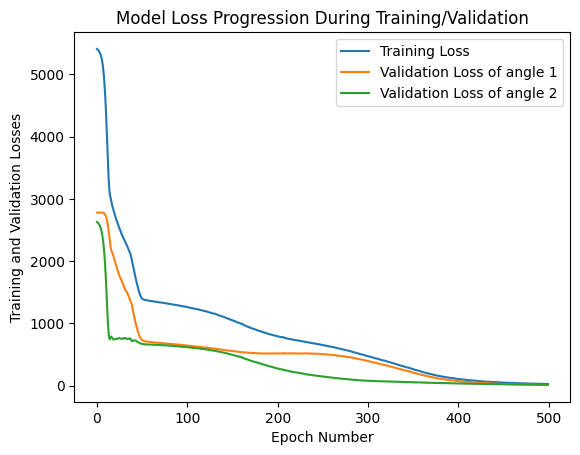

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['y_q_layer_loss'])
plt.plot(history.history['y_t_layer_loss'])


plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Training and Validation Losses')
plt.xlabel('Epoch Number')
plt.legend(['Training Loss', 'Validation Loss of angle 1', 'Validation Loss of angle 2'])

dict_keys(['loss', 'y_q_layer_loss', 'y_t_layer_loss', 'y_q_layer_root_mean_squared_error', 'y_t_layer_root_mean_squared_error', 'val_loss', 'val_y_q_layer_loss', 'val_y_t_layer_loss', 'val_y_q_layer_root_mean_squared_error', 'val_y_t_layer_root_mean_squared_error'])


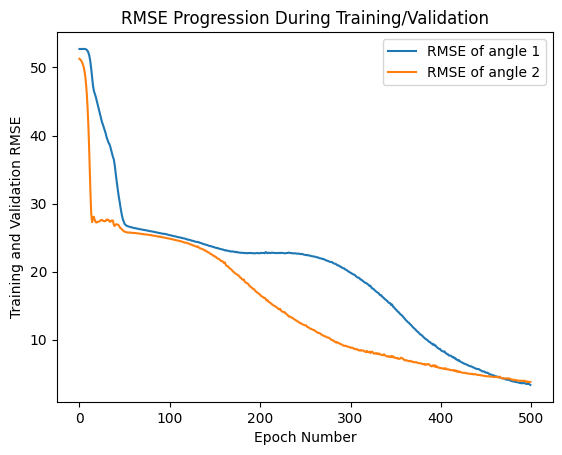

In [ ]:
print(history.history.keys())

plt.plot(history.history['y_q_layer_root_mean_squared_error'])
plt.plot(history.history['y_t_layer_root_mean_squared_error'])


plt.title('RMSE Progression During Training/Validation')
plt.ylabel('Training and Validation RMSE')
plt.xlabel('Epoch Number')
plt.legend(['RMSE of angle 1', 'RMSE of angle 2'])

In [ ]:
predicitons=model.predict(test_X)

3/3 [==============================] - 0s 6ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
mae_one = mean_absolute_error(test_y[0],predicitons[0])

In [ ]:
mae_one

27.463948978318108

In [ ]:
mae_two = mean_absolute_error(test_y[1],predicitons[1])

In [ ]:
mae_two

35.646315263377296